**Table of contents**<a id='toc0_'></a>    
- [Plug and Play: NHS Artificial Data](#toc1_)    
  - [Goals of this notebook](#toc1_1_)    
  - [Setup](#toc1_2_)    
  - [Data Ingestion](#toc1_3_)    
  - [Basic Queries and Visualisations](#toc1_4_)    
    - [Age Distribution](#toc1_4_1_)    
    - [Diagnoses](#toc1_4_2_)    
    - [Regional Distribution](#toc1_4_3_)    
    - [What's different then?](#toc1_4_4_)    
  - [Suggested Exercises](#toc1_5_)    
  - [Further Experiments & Full Sized Dataset](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Plug and Play: NHS Artificial Data](#toc0_)

So, you've seen the [artificial data pilot](https://digital.nhs.uk/services/artificial-data) - a tool which could help open up healthcare research on NHS datasets, and make life easier for researchers. But where to start?

We've made this handy notebook to help you get going; querying and visualising the artificial data.

## <a id='toc1_1_'></a>[Goals of this notebook](#toc0_)
This notebook is here to give a zero-effort point of access to the [artificial datasets we've released](https://digital.nhs.uk/services/artificial-data). 

In this notebook, we're hoping to introduce the artificial data, and make it as simple as possible to go ahead and start interacting with it. 



## <a id='toc1_2_'></a>[Setup](#toc0_)

We've deliberately chosen to host this in a Google Colab. You should be able to just open this, and start running the cells below, without having to worry about any setup. 
If, however, you want to run this code locally, you can go ahead and [clone from the repo](https://github.com/DanGoldwater1/artificial-data-plug-and-play). If you're doing that, we'd recommend that you also consult the [README](../README.md).

### Colab Setup:
If you're viewing this on Google Colab, run the following two cells:

In [ ]:
!git clone https://github.com/DanGoldwater1/artificial-data-plug-and-play.git
!pip install -r artificial-data-plug-and-play/requirements.txt

In [ ]:
import sys
sys.path.append('artificial-data-plug-and-play/')
db_location = 'artificial-data-plug-and-play/data/main_db.db'

### Non-Colab Setup
If you're viewing this anywhere other than Google Colab, un-comment the cell below and run it intsead. 

In [ ]:

# db_location = 'data/main_db.db'

## <a id='toc1_3_'></a>[Data Ingestion](#toc0_)
In order to query the artificial data, we will need to:
- fetch the data
- unzip the data
- combine the `.csv` files into a single parquet file, which can be queried _a la_ SQL.

The published datasets [we can explore](https://digital.nhs.uk/services/artificial-data) are as follows:

In [ ]:
'HES_A_E_sample'
'HES_A_E_full'
'HES_Admitted_Patient_Care_sample'
'HES_Admitted_Patient_care_full'
'HES_Outpatient_sample'
'HES_Outpatient_full'

Let's start off with the A&E sample data

In [2]:
import os
import duckdb
from src.data_ingestion import preprocessing
if os.path.exists(db_location):
    os.remove(db_location)
con = duckdb.connect(db_location)

preprocessing.download_and_transform_data(dataset_name='HES_A_E_sample',db_con=con)

Download and extraction complete.
Saved parquet file to data/HES_A_E_sample/HES_A_E_sample.parquet
Created table called HES_A_E_sample to query the data


In [3]:
%reload_ext autoreload
%autoreload 2

Next we want to use `duckdb` to connect with our data. This allows us to query the data using SQL, which mimics what you'll be doing if you proceed to working on real NHS data. 
We've also chosen to use a filetype and format which scales well. In this part of the notebook, we're only interacting with a small sample of data, and we could easily hold this in RAM as a python object. However, by choosing to convert our data to a parquet file, and to access it via duckdb, we are able to emulate the exact same practices which you would use if interacting with a much larger dataset - such as the full HES. 

## <a id='toc1_4_'></a>[Basic Queries and Visualisations](#toc0_)

We've now got data which we can query. Let's take a look at the metadata:

In [4]:
query = "PRAGMA table_info('HES_A_E_sample');"
schema_df = con.execute(query).fetchdf()

schema_df = schema_df[['name', 'type']]
display(schema_df)

,name,type
0,FYEAR,BIGINT
1,PARTYEAR,BIGINT
2,PSEUDO_HESID,VARCHAR
3,AEKEY,BIGINT
4,AEKEY_FLAG,BIGINT
...,...,...
161,NER_TREATMENT,VARCHAR
162,SITETRET,VARCHAR
163,SITEDIST,DOUBLE
164,SITEDIST_FLAG,DOUBLE


### <a id='toc1_4_1_'></a>[Age Distribution](#toc0_)
Now let's look at a single variable -- age.

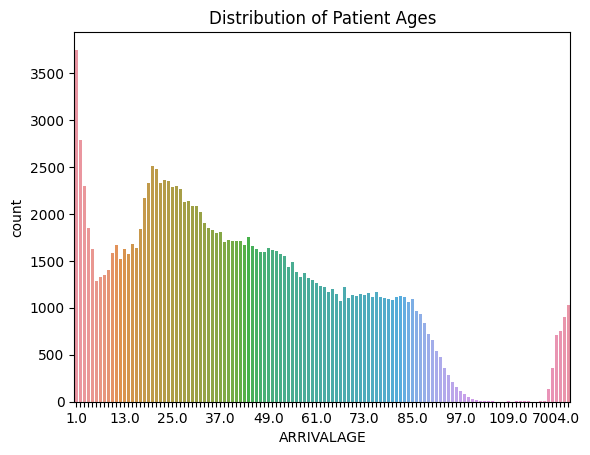

In [5]:
query_age = '''
SELECT ARRIVALAGE, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY ARRIVALAGE
ORDER BY ARRIVALAGE
'''
df1 = con.execute(query_age).fetchdf()
import matplotlib.pyplot as plt
import seaborn

plot = seaborn.barplot(data=df1, x='ARRIVALAGE', y='count')
plot.set_title('Distribution of Patient Ages')

n_x_labels_to_skip = 12 
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % n_x_labels_to_skip == 0:  # show only every nth label
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.show()


This plot demonstrates some important things about the artificial data:

- Notice that the distribution peaks around 20, and tails off after 80. This is because the column under study, `ARRIVALAGE`, will replicate the distribution in the real HES data. The values in this column will not correlate with those in any other column (unlike in the real HES data), but the distribution for this each variable alone will be statistically similar to the real thing. 
- At the high end of the $x$ axis, we can see some clustering up to the number $7004$. This looks like a straightforward error, but it is actually an artifact of how ages $< 1$ year are encoded. 

Information about the specific columns, including a description, and details about any encodings; can be found by downloading the HES Technical Specifications [stored on this page](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/hospital-episode-statistics/hospital-episode-statistics-data-dictionary). 

### <a id='toc1_4_2_'></a>[Diagnoses](#toc0_)

Text(0.5, 1.0, 'Most Common Diagnoses')

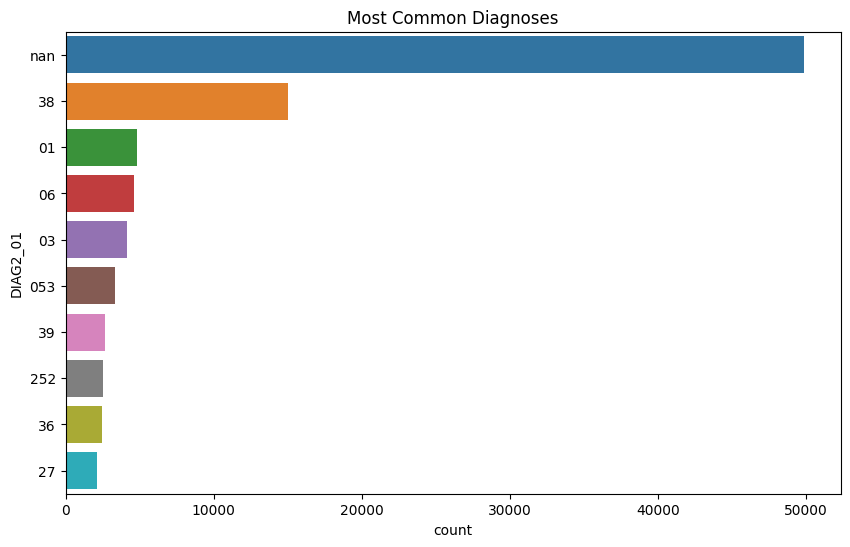

In [6]:

query2 = '''
SELECT DIAG2_01, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY DIAG2_01
ORDER BY count DESC
LIMIT 10
'''
df_diagnoses = con.execute(query2).fetchdf()
plt.figure(figsize=(10,6)) 
seaborn.barplot(data=df_diagnoses, x='count', y='DIAG2_01').set_title('Most Common Diagnoses')


### <a id='toc1_4_3_'></a>[Regional Distribution](#toc0_)
We can also look at the regional distrubution of our data. Again, this information is encoded in a specific way which matches that of the real HES data. The `RESGOR` column here gives each entry a single letter. We can de-code this via a dictionary which is, again, to be found in the Excel file [hosted on this page](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/hospital-episode-statistics/hospital-episode-statistics-data-dictionary). We have copied the dictionary into the next cell:

In [13]:
Region_Dict = {

    'A' : 'North East',
    'B' : 'North West',
    'C' : 'Merseyside (until 1998-99)',
    'D' : 'Yorkshire and Humber',
    'E' : 'East Midlands',
    'F' : 'West Midlands',
    'G' : 'East of England',
    'H' : 'London',
    'J' : 'South East',
    'K' : 'South West',
    'S' : 'Scotland',
    'U' : 'No fixed abode',
    'W' : 'Wales',
    'X' : 'Foreign (including Isle of Man and Channel Islands)',
    'Y' : 'Unknown',
    'Z' : 'Northern Ireland',
}

We can now go ahead and query / plot:

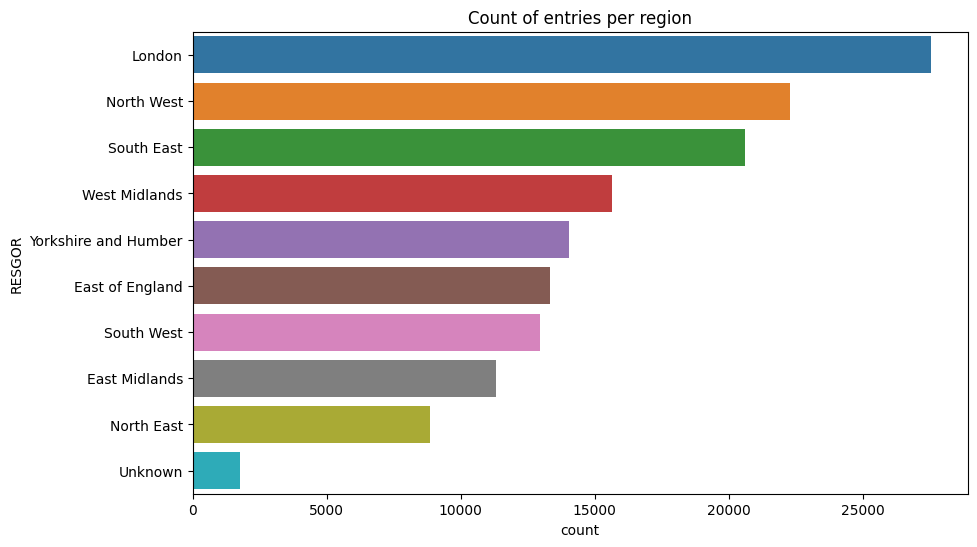

In [14]:

query = '''
SELECT RESGOR, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY RESGOR
ORDER BY count DESC
LIMIT 10
'''

df = con.execute(query).fetch_df()
df['RESGOR'] = df['RESGOR'].map(Region_Dict)

plt.figure(figsize=(10, 6))
seaborn.barplot(x='count', y='RESGOR', data=df)
plt.title('Count of entries per region')
plt.show()

### <a id='toc1_4_4_'></a>[What's different then?](#toc0_)

So, as explained on [the homepage for artificial data](https://digital.nhs.uk/services/artificial-data) - the distributions for each column in the artificial dataset will be statistically matched to those in the original HES data. So, each of the three plots which we've produced here would *look the same* if we ran them against an equivalent sample from the real HES_A_E table. 

However, that's as deep as the similarities go - aggregate level counts for single features; no correlations. So, if we wanted to see (for example), how age distributions varied per region, we would get something completely different to real HES data. In principle, all our regions ought to look roughly the same here; whereas in the real data, there's no reason for these features to be un-correlated. Let's have a look:


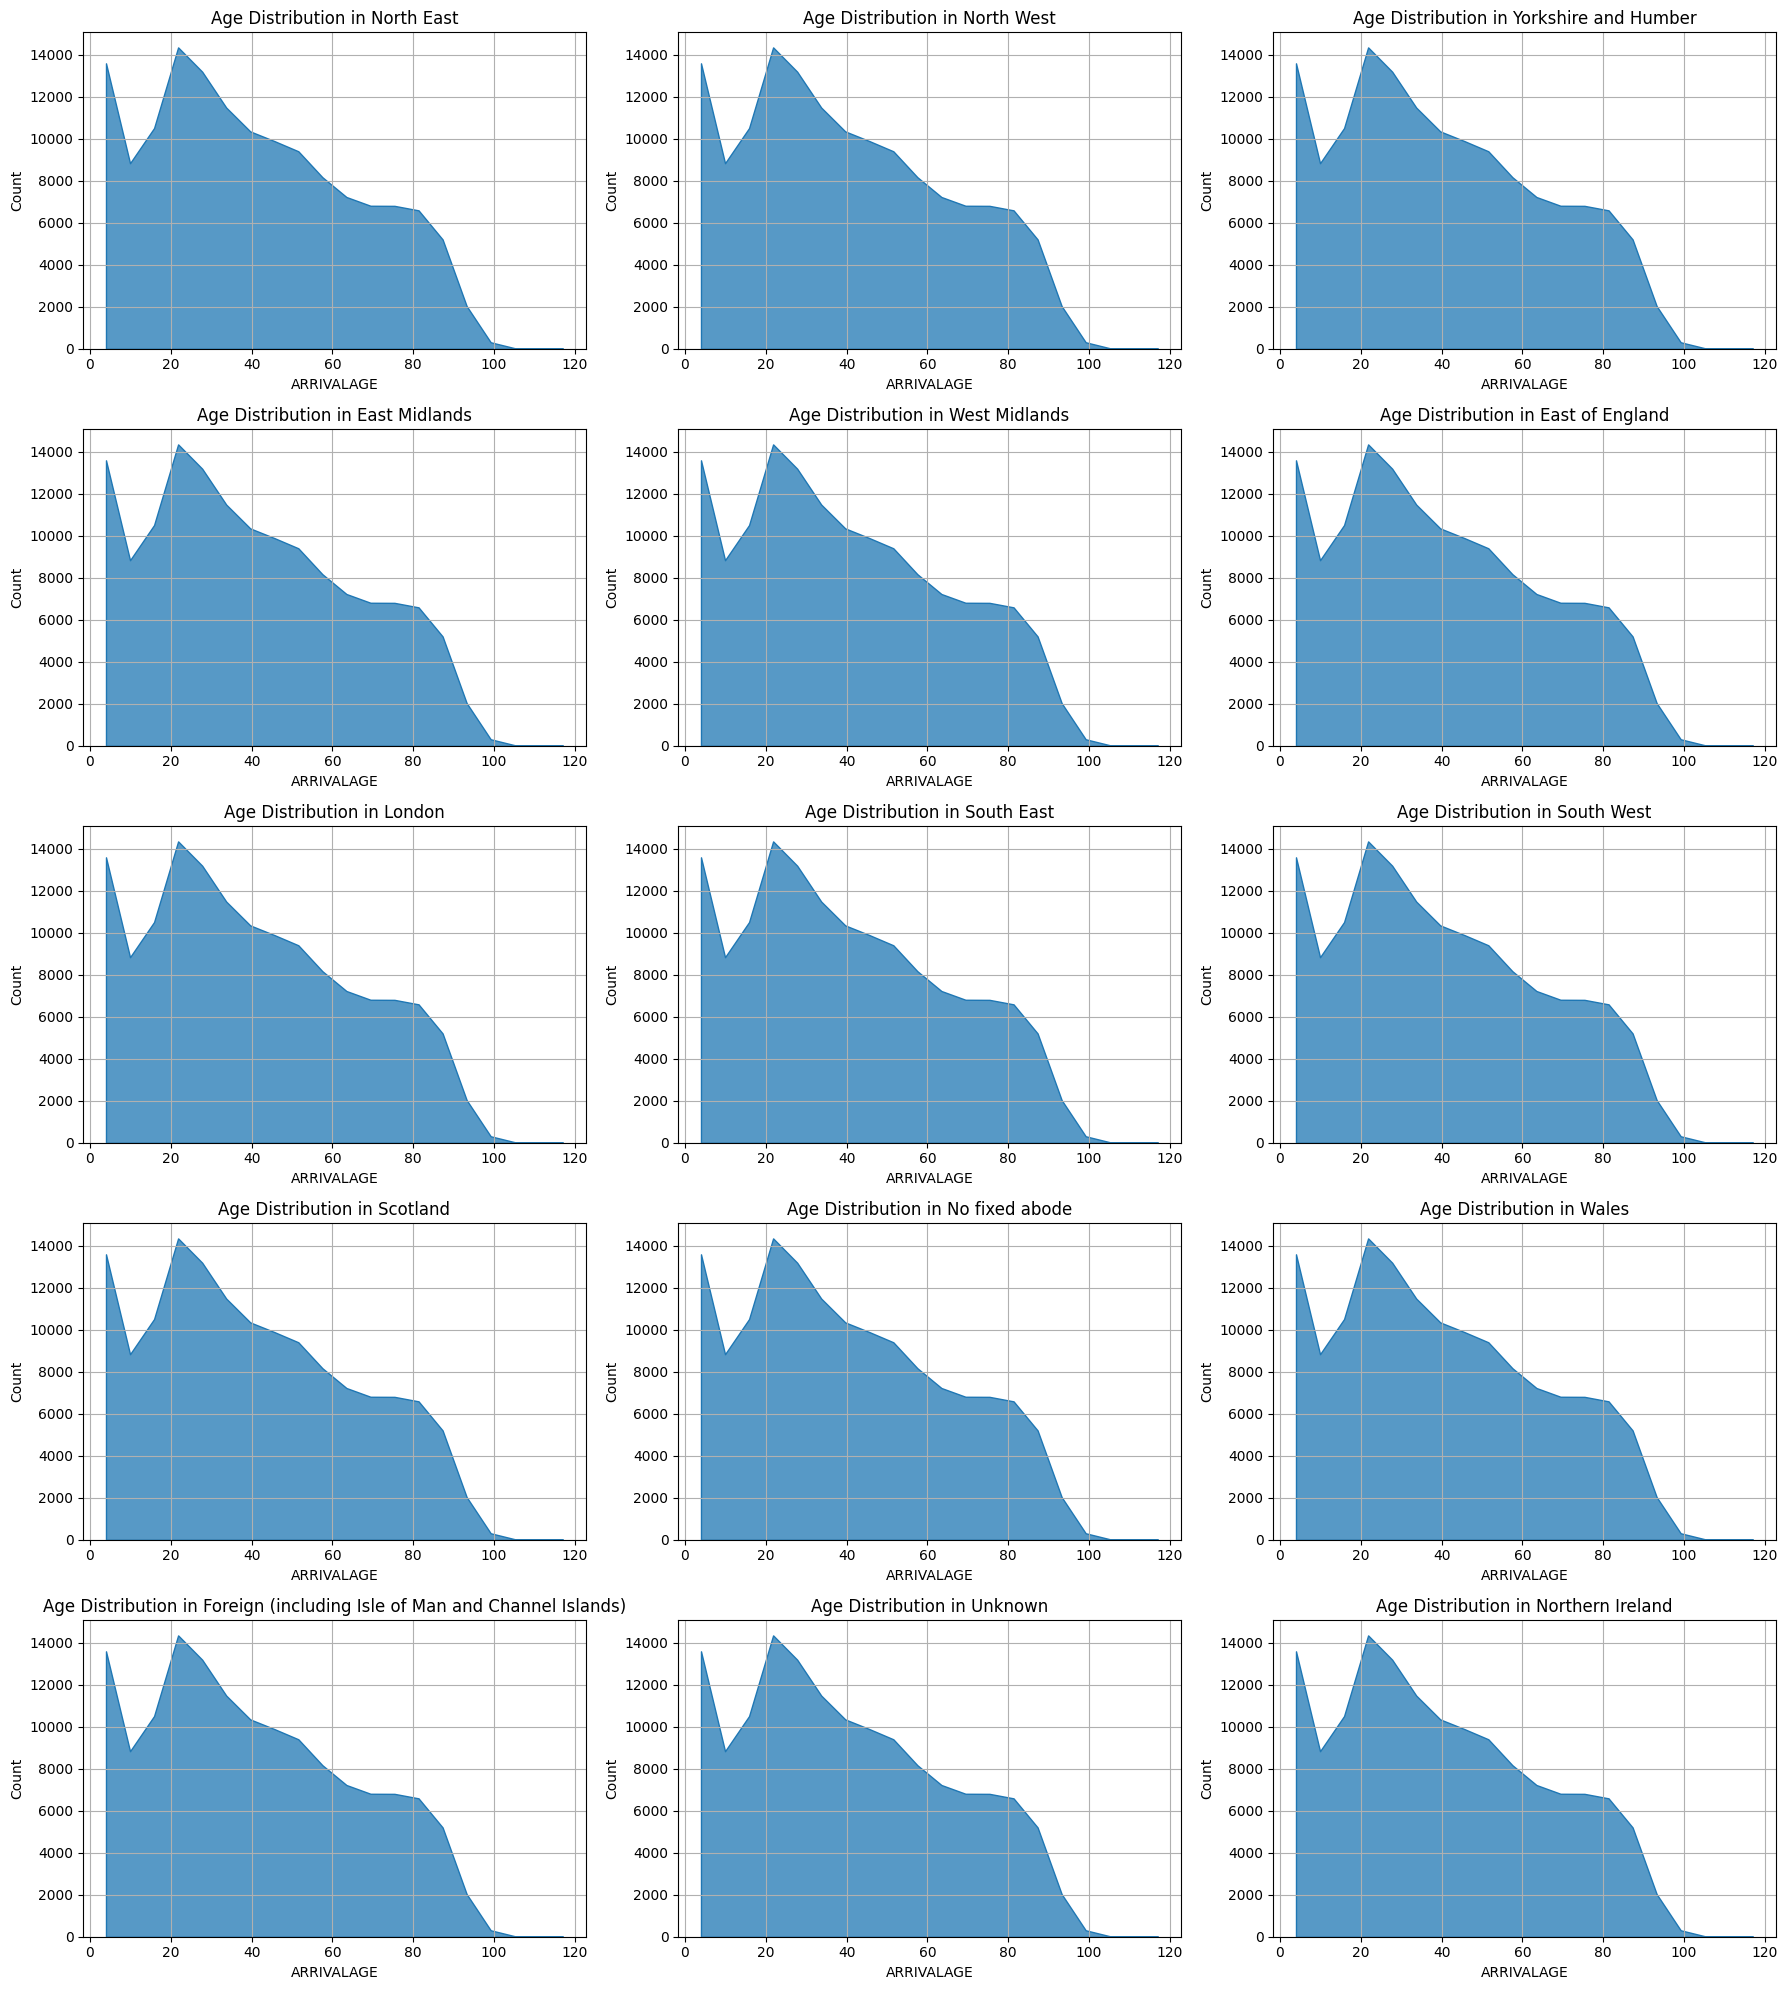

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

query = '''
SELECT RESGOR, ARRIVALAGE, COUNT(*) as count 
FROM HES_A_E_sample 
GROUP BY RESGOR, ARRIVALAGE
ORDER BY RESGOR, ARRIVALAGE
'''

unique_regions = df['RESGOR'].unique()
num_rows = math.ceil(len(unique_regions) / 3)
fig, axs = plt.subplots(num_rows, 3, figsize=(18, num_rows*4))  
axs = axs.flatten()

# Create a plot for each region. Here we are going to ignore the artefact of ages > 700
for i, region in enumerate(unique_regions):
    region_data = df[df['RESGOR'] == region]
    region_data = df[df['ARRIVALAGE'] < 200]
    sns.histplot(data=region_data, x='ARRIVALAGE', weights='count', bins=20, ax=axs[i], element='poly')
    axs[i].set_title(f'Age Distribution in {region}')
    axs[i].grid(True)

# Remove empty subplots
for j in range(i+1, num_rows*3):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


As we can see - all of these look almost identical! 

This helps to highlight how useful the artificial datasets are. Here we can explore the schemas of the datasets, we can get our queries right, and we can become familiar with the quirks and oddities of some of the NHS' most important data assets. We can use these to build up analytical programs, and to test out our code. And we can do all of this without having to navigate the difficulties of information governance or secure systems - because these artificial datasets contain no real data at all - just a very helpful simulacrum of it. 

By doing development this here, on an open dataset, you'll be able to make much better use of your time if you do go on to do research on the real assets. You will have dealt with the bugs in your code, the naming conventions in the dataset, and so on. 

You can even begin to test the computational demands which come with large-scale datasets - see below. 

## <a id='toc1_5_'></a>[Suggested Exercises](#toc0_)

1. Can you modify the above cell so that you see diganoses per region, rather than arrival age?.
2. Pick a column at random, and look it up in the Tehcnical Output Specification [from this page](https://digital.nhs.uk/data-and-information/data-tools-and-services/data-services/hospital-episode-statistics/hospital-episode-statistics-data-dictionary).
3. Load one of the other sample datasets in, and run some analysis on it. At the top of this notebook, we have a list of the artificial datasets available for download. Sub out `'HES_AE_sample'` for one of the other names, and explore it.
4. Try some analysis against a full-sized dataset. This is explained below. 

## <a id='toc1_6_'></a>[Further Experiments & Full Sized Dataset](#toc0_)
If we want to experiment with how compute fares against more realistically sized datasets, we can move from the A&E sample dataset, we can try working with the full sized set. 

The difference between these two is that the sample set contains 10k rows, whereas the full set contains 1 million. 

This difference in scale will be important for how you process data and run queries. You can use this dataset to help test your hardware, and get an idea of how computationally expensive your analysis will be to run against real HES data. 

Note that, while the `full` artificial HES dataset which we're about to download is indeed large; it still only corresponds to *one year's* worth of HES data - so, expect to scale up your compute needs for the real thing. 

The cell below will:
1 download the full dataset
2 extract it all from a zip file, and combine it into a single parquet file
3 create a local table for you to query

Step 1 will be limited by your internet connection speed. Step 2 will be limited by your RAM and processing speed. Again; this serves as a useful test of your hardware. If the cell below takes > 10 minutes to run, don't worry. If it encounters an problem, it ought to throw an error. 


**NOTE: If you are viewing this through Google Colab, the compute instance you are running on will most likely not have the resources to handle the large filesizes involved. You can always [clone the original repo](https://github.com/DanGoldwater1/artificial-data-plug-and-play) and try the same process on a system with more RAM.**

In [ ]:

# preprocessing.download_and_transform_data(
#     dataset_name='HES_A_E_full',
#     db_con=con)